In [2]:
# %load convertChatToTable.py
import pandas as pd
import re

class ChatProcessor:

    def __init__(self):
        self.df = self.procesar_chat()

    def starWithDateAndTime(self, s):
        patron = '^\[([0-9]{1,2}\/[0-9]{1,2}\/[0-9]{2}), ([0-9]{2}:[0-9]{2}:[0-9]{2})\] '
        result = re.match(patron, s)
        if result:
            return True
        else:
            return False


    def findMembers(self, s):
        patterns = [
            '([\w]+):',  # Nombre
            '([\w]+[\s]+[\(]+[\w]+[\)]+):',  # Nombre (Apodo)
            '([\w]+[\s]+[\w]+):',  # Nombre + Apellido
            '([\w]+[\s]+[\w]+[\s]+[\w]+):',  # Nombre 1 + Nombre 2 + Apellido
            '([+]\d{2} \d{3} \d{3} \d{4}):',  # Número de teléfono (Peru)
            '([\w]+[\s])[\u263a-\U0001f999]+:',  # Nombre + Emoji
        ]

        pattern = '^' + '|'.join(patterns)
        result = re.match(pattern, s)
        if result:
            return True
        else:
            return False


    def GetParts(self, linea):
        # Ejemplo: '21/2/2021 11:27 a. m. - Sandro: Todos debemos aprender a analizar datos'
        splitLinea = linea.split(']', 1)
        fechaHora = splitLinea[0] + ']'  # '21/2/2021 11:27 a. m.'
        splitFechaHora = fechaHora.split(', ')
        fecha = splitFechaHora[0][1:]  # '21/2/2021'
        hora = ' '.join(splitFechaHora[1:])[:-1]  # '11:27 a. m.'
        mensaje = splitLinea[1].strip()  # 'Sandro: Todos debemos aprender a analizar datos'
        if self.findMembers(mensaje):
            splitMensaje = mensaje.split(': ')
            miembro = splitMensaje[0]  # 'Sandro'
            mensaje = ' '.join(splitMensaje[1:])  # 'Todos debemos aprender a analizar datos'
        else:
            miembro = None
        return fecha, hora, miembro, mensaje

    def procesar_chat(self):

        chatRoute = 'chat.txt'
        chatList = []

        with open(chatRoute, encoding="utf-8") as fp:
            fp.readline()  # Eliminar primera fila relacionada al cifrado de extremo a extremo
            VerificarMensaje = []  # Lista para verificar que no existan mensajes vacíos
            Fecha, Hora, Miembro = None, None, None
            while True:
                linea = fp.readline()
                if not linea:
                    break
                linea = linea.strip()
                if self.starWithDateAndTime(linea):  # Si cada línea del txt coincide con el patrón fecha y hora
                    if len(VerificarMensaje) > 0:
                        # Añadir un elemento lista que contendrá los datos a la lista 'DatosLista'
                        chatList.append([Fecha, Hora, Miembro, ' '.join(VerificarMensaje)])
                    VerificarMensaje.clear()
                    Fecha, Hora, Miembro, Mensaje = self.GetParts(linea)  # Obtener datos de cada línea del txt
                    VerificarMensaje.append(Mensaje)
                else:
                    VerificarMensaje.append(linea)

            # Convertir la lista con los datos a dataframe
        df = pd.DataFrame(chatList, columns=['Fecha', 'Hora', 'Miembro', 'Mensaje'])

        # Cambiar la columna Fecha a formato datetime
        df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d/%m/%y")

        # Eliminar los posibles campos vacíos del dataframe
        # y lo que no son mensajes como cambiar el asunto del grupo o agregar a alguien
        df = df.dropna()

        # Rester el índice
        # df.reset_index(drop=True, inplace=True)
        # print(df)
        return df

procesador = ChatProcessor()



In [ ]:
# %load whatsappDataAnalyst.py
import pandas as pd
import re

import regex
import emoji

import numpy as np
from collections import Counter

import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from convertChatToTable import ChatProcessor


def get_emojis(message):
    emoji_list = []
    data = regex.findall(r'\X', message)

    for character in data:
        if character in emoji.EMOJI_DATA:
            emoji_list.append(character)

    return emoji_list


# Crear una instancia de la clase ProcesadorChat
procesador = ChatProcessor()

# Acceder al DataFrame df desde la instancia
df = procesador.df

omitted_messages = ['image omitted', 'audio omitted', 'sticker omitted', 'video omitted', 'document omitted',
                    'GIF omitted', 'Contact card omitted']

total_messages = df.shape[0]

# Filtrar mensajes que terminan con "document omitted"
document_messages = df[df['Mensaje'].str.endswith('document omitted')].shape[0]

multimedia_messages = df[df['Mensaje'].isin(omitted_messages)].shape[0] + document_messages
# elementos_unicos = df[df['Mensaje'].str.contains('omitted', case=False)]['Mensaje'].unique()

# Obtener Cantidad de emojis
df['Emojis'] = df['Mensaje'].apply(get_emojis)  # Se agrega columna 'Emojis'
emojis = sum(df['Emojis'].str.len())

# Get links sent
url_pattern = r'(https?://\S+)'
df['urls'] = df.Mensaje.apply(lambda x: re.findall(url_pattern, x)).str.len()  # Added column 'urls'
links = np.sum(df.urls)

# Polls created
polls = len(df[df['Mensaje'].str.contains('POLL:', case=False)])

stadistics_dict = {'Tipo': ['Messages', 'Multimedia', 'Emojis', 'Links', 'Polls'],
                   'Cantidad': [total_messages, multimedia_messages, emojis, links, polls]}

#Convertir diccionario a dataframe
stadistics_df = pd.DataFrame(stadistics_dict, columns=['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
stadistics_df = stadistics_df.set_index('Tipo')
# stadistics_df

# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji')

# print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df.head(10)
emoji_df_for_chart = emoji_df.head(10)

fig_emoji = px.pie(emoji_df_for_chart, values='Cantidad', names=emoji_df_for_chart.index, title="Emojis Pie Chart")
fig_emoji.update_traces(textposition='inside', textinfo='percent+label')
fig_emoji.update_layout(width=800, height=800)
# fig_emoji.show()
# Identificar a todos los miembros del grupo
df.Miembro.unique()


# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos.head(10)
df_MiembrosActivos

# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'].isin(omitted_messages)]
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))
mensajes_df.tail()


# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
  lista = []
  # Filtrar mensajes de un miembro en específico
  miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

  # Agregar a la lista el número total de mensajes enviados
  lista.append(miembro_df.shape[0])

  # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
  palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
  lista.append(palabras_por_msj )

  # Agregar a la lista el número de mensajes multimedia enviados
  multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
  lista.append(multimedia)

  # Agregar a la lista el número total de emojis enviados
  emojis = sum(miembro_df['Emojis'].str.len())
  lista.append(emojis)

  # Agregar a la lista el número total de links enviados
  links = sum(miembro_df['urls'])
  lista.append(links)

  # Asignar la lista como valor a la llave del diccionario
  dictionario[miembros[i]] = lista
# print(dictionario)


# Convertir Diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)
# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Palabras por mensaje', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)
miembro_stats_df.sort_values(by=['Mensajes'], ascending=False)


df['rangoHora'] = pd.to_datetime(df['Hora'], format='%H:%M:%S')

# Define a function to create the "Range Hour" column
def create_range_hour(hour):
    start_hour = hour.hour
    end_hour = (hour + pd.Timedelta(hours=1)).hour
    return f'{start_hour:02d} - {end_hour:02d} h'

# # Apply the function to create the "Range Hour" column
df['rangoHora'] = df['rangoHora'].apply(create_range_hour)
df


# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por hora'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('rangoHora').count()
date_df.reset_index(inplace=True)

# Plotear la cantidad de mensajes respecto del tiempo
fig1 = px.line(date_df, x='rangoHora', y='# Mensajes por hora')

# Ajustar el gráfico
fig1.update_layout(
    title={'text': 'Cantidad de mensajes vs Tiempo',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'},
    font=dict(size=17))
fig1.update_xaxes(title_text='Rango de hora', tickangle=30)
fig1.update_yaxes(title_text='# Mensajes')
# fig1.show()

# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('Fecha').sum()
date_df.reset_index(inplace=True)

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='Fecha', y='# Mensajes por día')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Cantidad de mensajes vs Tiempo',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'},
    font=dict(size=17))
fig.update_xaxes(title_text='Fecha', tickangle=45, nticks=35)
fig.update_yaxes(title_text='# Mensajes')
# fig.show()

# Crear un string que contendrá todas las palabras
total_palabras = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
                                                         'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic', 'nos', 'ya', 'hay', 'esta',
                                                         'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https', 'tu', 'y', 'al',
                                                         'mi', 'tus', 'esa', 'o', 'sus', 'tiene', 'también', 'tambien', 'sea', 'esos', 'esto', 'ese',
                                                         'uno', 'ahi', 'ahí', 'va', 'está', 'yo', 'tenga', 'ser', 'otra', 'otro', 'mis', 'han', 'porque'])

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in mensajes_df['Mensaje'].values:
  palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
  for palabra in palabras:
    total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

wordcloud = WordCloud(width = 1000, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(total_palabras)

# Plotear la nube de palabras más usadas
# print(wordcloud)

# wordcloud.to_image()



# Viaje a través de Nuestro Chat de WhatsApp 💑💬



## Introducción

En este recorrido, exploraremos nuestro mundo de conversaciones en WhatsApp. Desde el primer "Hola" hasta los emoticones que hacen que nuestro corazón sonría. ¡Vamos juntos a recordar esos momentos especiales!

## Nuestro Chat en Números 💬📊

### Nuestra Conexión Única

En este viaje numérico a través de nuestro chat, descubriremos cuántos mensajes hemos intercambiado. Cada palabra, una expresión única de nuestro vínculo, una conversación que solo nosotros entendemos.

In [10]:
df_MiembrosActivos

,Miembro,Mensaje
1,Raynier,14482
2,Negra ❤️,13756


### Emojis, los Pequeños Emisarios de Nuestro Amor 💖

#### Descifrando Nuestros Emoticones

Los emoticones son nuestras pequeñas expresiones digitales, nuestros cómplices silenciosos. Desde la risa contagiosa hasta los corazones que laten juntos, estos emoticones cuentan la historia de nuestro amor en pequeños iconos llenos de significado.

In [12]:
emoji_df_for_chart

,Cantidad
Emoji,
❤️,300
🤣,242
😍,226
🤭,173
🫣,158
😪,144
😌,139
🥲,124
🤤,115


#### El Colorido Pastel de Nuestros Sentimientos

Imagina un pastel adornado con los emojis que más usamos. Cada rebanada cuenta una historia, cada color refleja una emoción compartida. Este pastel es un festín visual de nuestra conexión emocional.

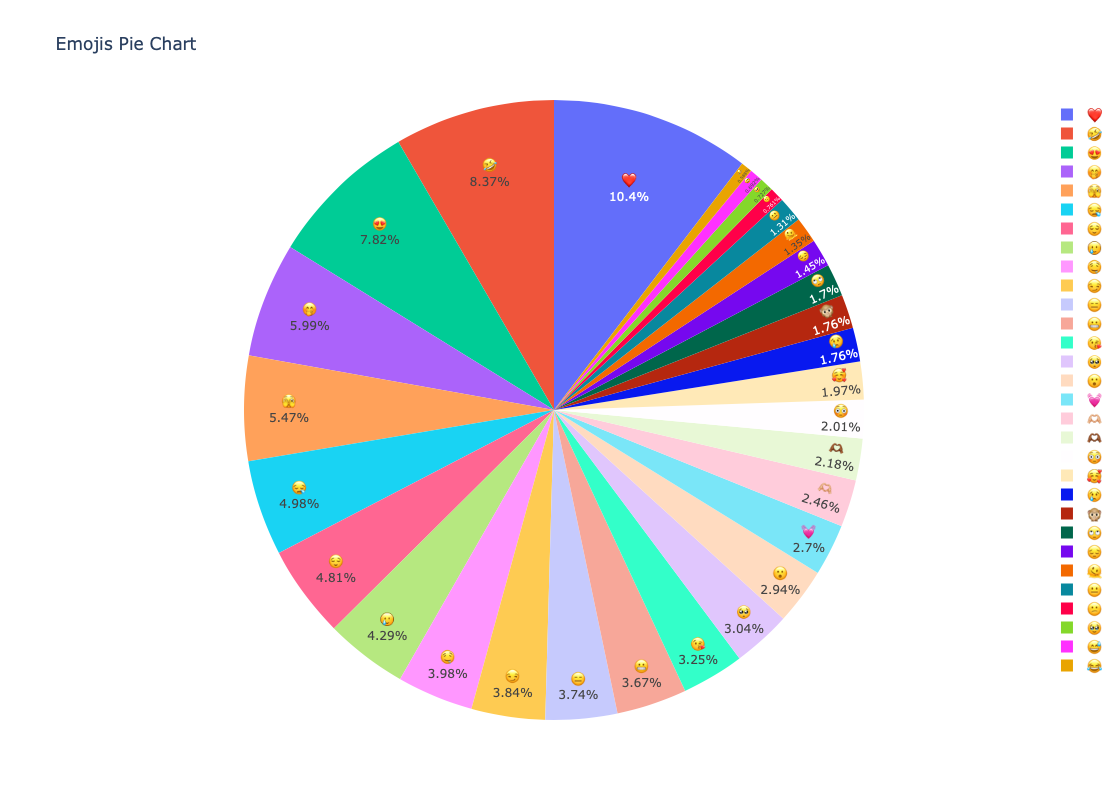

In [13]:
fig_emoji.show()

### Instantáneas de Nuestro Mundo 📸


En esta sección, echaremos un vistazo a las instantáneas de nuestro mundo digital. Desde mensajes escritos con amor hasta momentos compartidos en forma de fotos, exploraremos la diversidad de nuestra comunicación y los recuerdos multimedia que hemos coleccionado.

In [15]:
stadistics_df

,Cantidad
Tipo,
Messages,28238
Multimedia,6717
Emojis,3205
Links,201
Polls,3


In [16]:
miembro_stats_df

Estadísticas,Mensajes,Palabras por mensaje,Multimedia,Emojis,Links
Raynier,12655,7.312130,1827,1659,71
Negra ❤️,8894,5.698111,4862,1546,130


## Detalles Especiales 💖✨

### Nuestras Horas Mágicas ⌛💫

Las horas mágicas son esos momentos del día en los que nuestros mensajes florecen. Ya sea en la serenidad de la mañana o en la calidez de la noche, descubriremos cuándo nuestras palabras cobran vida con mayor intensidad.



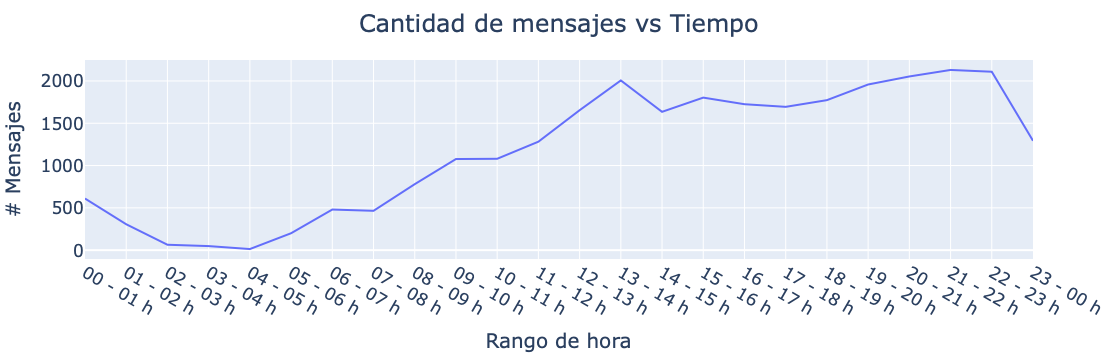

In [17]:
fig1.show()

### Nuestro Calendario del Amor 📅❤️

Este calendario es más que fechas; es un registro de nuestro compromiso diario. Observaremos cómo nuestros mensajes se entrelazan en el tiempo, creando un patrón que refleja el flujo constante de nuestro amor a lo largo de los días.



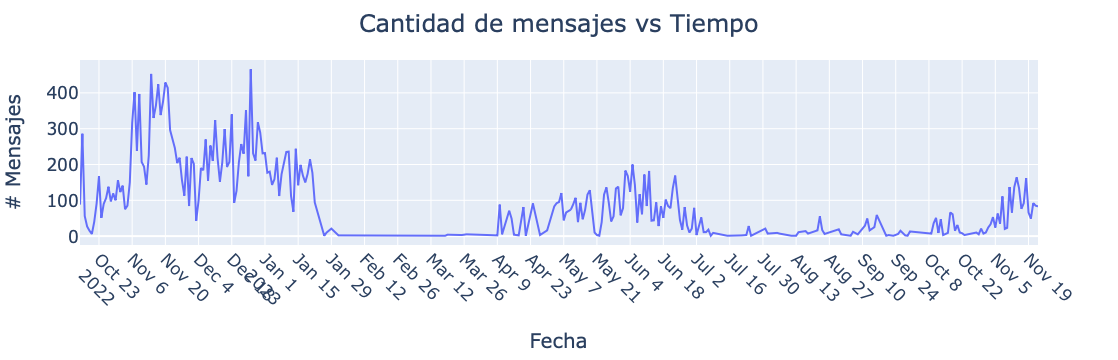

In [18]:
fig.show()

### El Poema de Nuestras Palabras 📜🖋️


Cada palabra que compartimos es una línea en el poema de nuestro amor. En esta sección, exploraremos las palabras más usadas, creando una nube de términos que resalta las esencias más dulces y comunes de nuestras conversaciones.

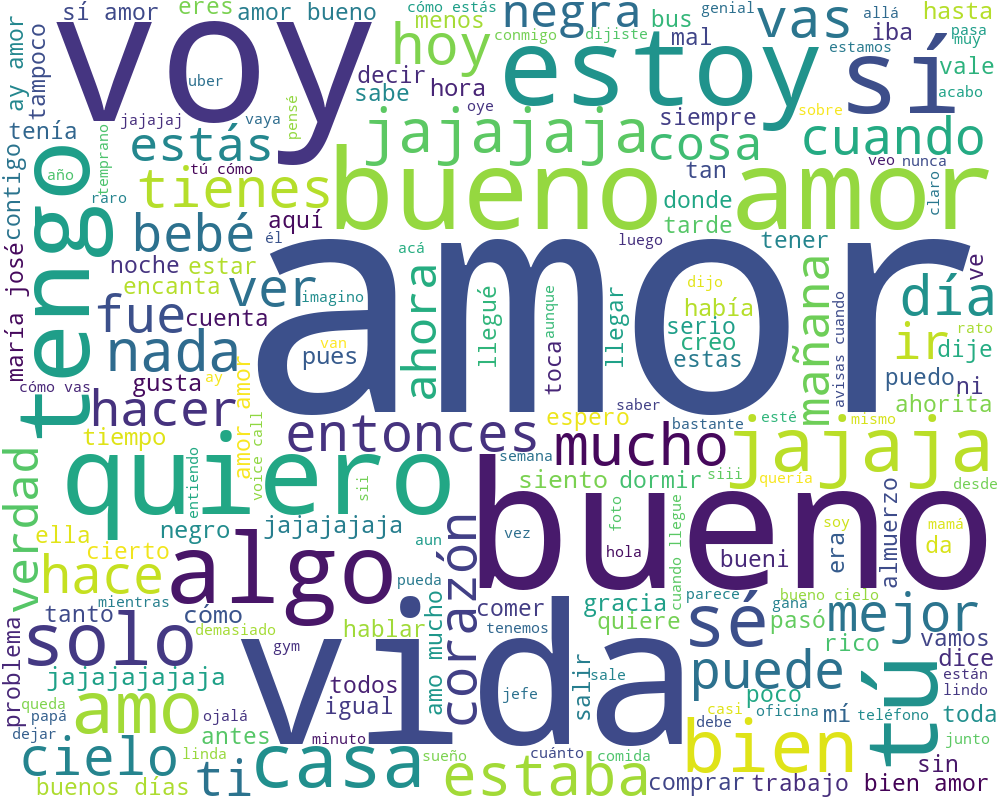

In [19]:
wordcloud.to_image()

## Reflexiones de Nuestro Viaje 💭💕

En este viaje a través de nuestro chat, hemos revivido esos momentos que solo tú y yo entendemos. Cada emoji, cada palabra, cada enlace es una pequeña pieza de nuestro amor que ha quedado registrado. Gracias por ser mi compañera de viaje en este hermoso chat de WhatsApp.

---